<a href="https://colab.research.google.com/github/giorginolab/2025-Markov-Tutorial-UniPd/blob/main/3_Markov_Python_Deeptime_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install condacolab
import condacolab
condacolab.install()
!conda install -q deeptime
# %pip install deeptime==0.4.3

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import deeptime as dt

# 3 States: the weather example


A "1D" example with 3 states.

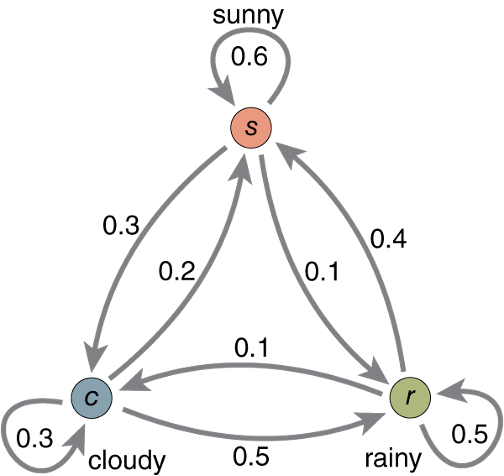

In [21]:
Pij = np.array([[0.6, 0.3, 0.1],
               [0.2, 0.3, 0.5],
               [0.4, 0.1, 0.5]])


In [22]:
def sampleP(P, x0=0, k=10):
  """Sample the discrete-time Markov chain with given transition matrix P,
     starting from state x0, n samples"""
  import random
  r = []
  Nstates, _ = P.shape  # Size of the matrix
  for i in range(k):
    P_current_row=P[x0,:]
    x=random.choices(range(Nstates), weights=P_current_row)
    x=x[0]              # List of size 1 to scalar
    r.append(x)
    x0=x
  return r


In [23]:
sampled = sampleP(Pij, k=1000)
sampled[:20]

[0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [24]:
frequencies = np.bincount(sampled)
frequencies

array([465, 238, 297])

In [25]:
dG = -0.6 * np.log(frequencies)
dG = dG-np.min(dG)
dG

array([0.        , 0.40186004, 0.26898316])

In [26]:
# The exact asymptotic values can be computed numerically
eva, eve = np.linalg.eig(Pij.T)

print("Eigenvalues: ",eva)
print("First eigenvector, normalized to sum 1:")
print(eve[:,0]/np.sum(eve[:,0]))

Eigenvalues:  [1. +0.j  0.2+0.2j 0.2-0.2j]
First eigenvector, normalized to sum 1:
[0.44117647+0.j 0.23529412+0.j 0.32352941+0.j]


# Now a slightly less-synthetic example

Suppose 100 states in a sequence (1D). From https://deeptime-ml.github.io/latest/datasets/sdes/plot_tmatrix_1d.html#sphx-glr-datasets-sdes-plot-tmatrix-1d-py

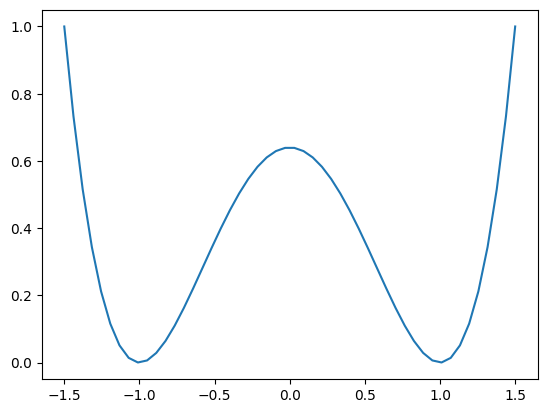

In [27]:
xs = np.linspace(-1.5, 1.5, num=50)
energies = 1/8 * (xs-1)**2 * (xs+1)**2
energies /= np.max(energies)

plt.plot(xs,energies)

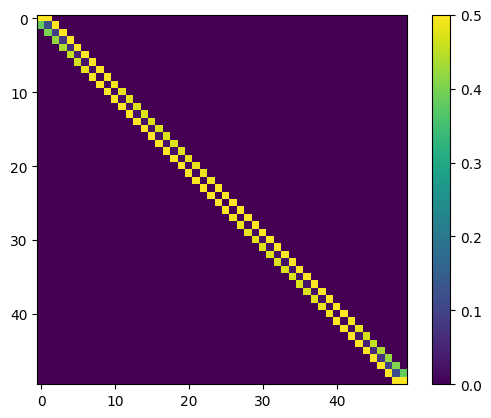

In [28]:
transition_matrix = dt.data.tmatrix_metropolis1d(energies)

plt.imshow(transition_matrix)
plt.colorbar()

In [29]:
msm = dt.markov.msm.MarkovStateModel(transition_matrix)

In [30]:
traj = msm.simulate(n_steps=200000)

In [31]:
#msm = dt.markov.msm.MarkovStateModel(transition_matrix=np.array([[.7, .3], [.3, .7]]))
#trajectory = msm.simulate(n_steps=15)
#trajectory

In [32]:
transition_matrix

array([[0.5       , 0.5       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.38277478, 0.11722522, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.40240623, 0.09759377, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.09759377, 0.40240623,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.5       , 0.11722522,
        0.38277478],
       [0.        , 0.        , 0.        , ..., 0.        , 0.5       ,
        0.5       ]])

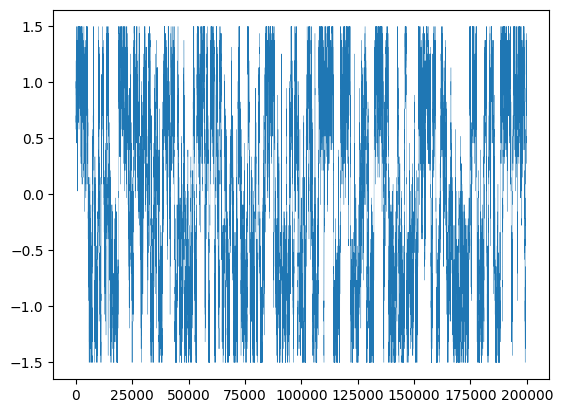

In [33]:
plt.plot(xs[traj], linewidth=.2)

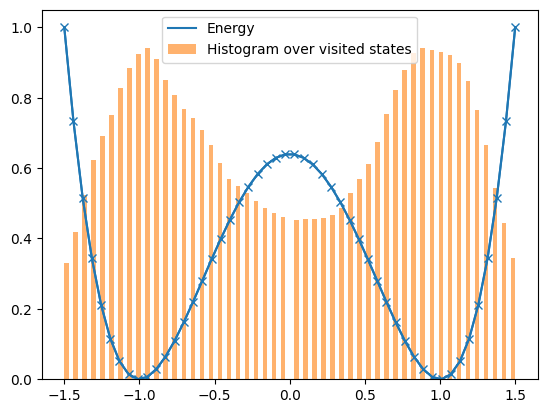

In [34]:
# Assume we are at equilibrium: histogram (frequency of states)

plt.plot(xs, energies, color='C0', label='Energy')
plt.plot(xs, energies, marker='x', color='C0')

plt.hist(xs[traj], bins=100, density=True, alpha=.6, color='C1', label='Histogram over visited states')
plt.legend()

plt.show()

In [35]:
# Now reconstruct the model from the data
estimator = dt.markov.TransitionCountEstimator(lagtime=1, count_mode="sliding")
model = estimator.fit(traj).fetch_model()

In [36]:
reconstructed_msm = dt.markov.msm.MaximumLikelihoodMSM().fit_fetch(estimator)

In [37]:
reconstructed_msm.stationary_distribution

array([0.00990449, 0.01254436, 0.01570919, 0.01864904, 0.02071893,
       0.02252884, 0.02486371, 0.02651862, 0.02770855, 0.02825852,
       0.02725356, 0.02546865, 0.0242487 , 0.02301876, 0.02224879,
       0.02121883, 0.01997389, 0.01843396, 0.01708402, 0.01645905,
       0.01584907, 0.01517909, 0.01456411, 0.01418412, 0.01384913,
       0.01361413, 0.01363911, 0.0136491 , 0.01378407, 0.01399404,
       0.01462399, 0.01586888, 0.01710378, 0.01831368, 0.02022853,
       0.02261334, 0.02469318, 0.02637304, 0.02781293, 0.02824289,
       0.02810289, 0.02792798, 0.0276679 , 0.02695269, 0.02542725,
       0.02295654, 0.01999069, 0.01632965, 0.01328878, 0.01036295])

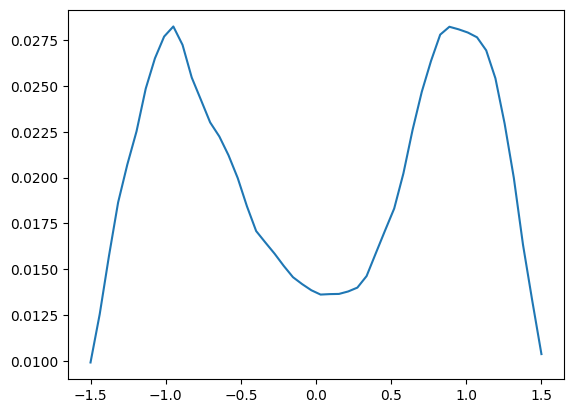

In [38]:
plt.plot(xs,reconstructed_msm.stationary_distribution)

Now let's compute a series of models at different τ values.


In [39]:
models = []
lagtimes = np.arange(1, 1000, 100)
for lagtime in lagtimes:
    counts = dt.markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(traj)
    models.append(dt.markov.msm.MaximumLikelihoodMSM().fit_fetch(counts))

<Axes: >

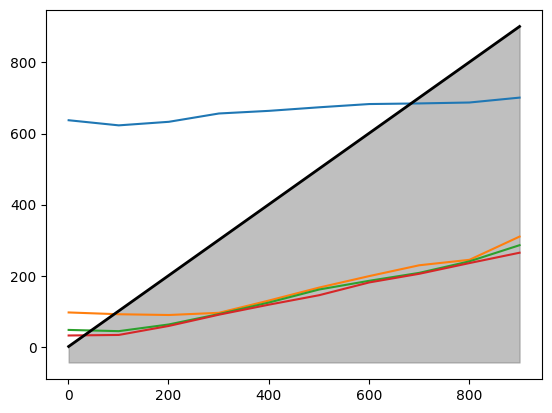

In [40]:
its_data = dt.util.validation.implied_timescales(models)

fig, ax = plt.subplots(1, 1)
dt.plots.plot_implied_timescales(its_data, n_its=4, ax=ax)

# Use real data from Fuxreiter et al.

Data from https://zenodo.org/record/7657119 related to the paper

> Gönczi, M., Teixeira, J.M.C., Barrera-Vilarmau, S. et al. Alternatively spliced exon regulates context-dependent MEF2D higher-order assembly during myogenesis. Nat Commun 14, 1329 (2023). https://doi.org/10.1038/s41467-023-37017-7


Very important: there are 10,000 frames in each trajectory. The paper says that each trajectory corresponds to 100 ns. Hence, snapshots are taken every 10 ps.


In [41]:
# !rm -f *.netcdf   # If needed

In [42]:
!curl -JLO -C- https://zenodo.org/record/7657119/files/MEF2D_wt.prmtop
!curl -JLO -C- 'https://zenodo.org/record/7657119/files/MEF2D_wt_sim[1-3].netcdf'


curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
curl: --continue-at and --remote-header-name cannot be combined
curl: try 'curl --help' or 'curl --manual' for more information
curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
curl: --continue-at and --remote-header-name cannot be combined
curl: try 'curl --help' or 'curl --manual' for more information


In [43]:
# You can convert trajectories to xtc or DCD as follows if needed. For Pymol,
# rename the files: *.netcdf -> *.nc and load them together with the *.prmtop
# !mdconvert -o MEF2D_wt_sim1.xtc -t MEF2D_wt.prmtop MEF2D_wt_sim1.netcdf

## Load the 3 trajectories

In [44]:
#!conda install -q mdtraj
%pip install mdtraj
import mdtraj as mdt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.5 MB/s eta 0:00:00


In [45]:
t1 = mdt.load('MEF2D_wt_sim1.netcdf', top='MEF2D_wt.prmtop')
t2 = mdt.load('MEF2D_wt_sim2.netcdf', top='MEF2D_wt.prmtop')
t3 = mdt.load('MEF2D_wt_sim3.netcdf', top='MEF2D_wt.prmtop')

FileNotFoundError: [Errno 2] No such file or directory: 'MEF2D_wt.prmtop'

In [ ]:
print(t1.n_residues)
print(t1.n_atoms)
print(t1.n_frames)

## Compute contacts

In [ ]:
cont1, pairs1=mdt.compute_contacts(t1)

In [ ]:
# Interpretation: rows as frames, columns are the (selected) atom pairs
cont1.shape

In [ ]:
# Interpretation: rows as atom pairs, columns indicate atom1 and atom2
pairs1.shape

In [ ]:
pairs1[:,:]

In [ ]:
# Contacts in the first frame
cont1[0,:40]

In [ ]:
plt.imshow(mdt.geometry.squareform(cont1, pairs1)[0,:,:])

In [ ]:
# The soft_min transformation is not clear
tmp,_=mdt.compute_contacts(t1, soft_min=True)
plt.scatter(cont1[0,:],tmp[0,:])

## Project with TICA

In [ ]:
from deeptime.decomposition import TICA
tica = TICA(dim=2, lagtime=5)
data_tica = tica.fit(cont1)
model1 = tica.fetch_model()

In [ ]:
prj1=model1.transform(cont1)

In [ ]:
plt.scatter(prj1[:,0],prj1[:,1],c=range(10000))
plt.colorbar()

It looks like *this* trajectory took 2000 frames (20 ns) to equilibrate. The paper dropped the first 70 ns.

Note how (100 ns-70 ns)*3 = 90 ns = 90000 ps = 9000 snapshots.

In [ ]:
plt.plot(prj1[2000:,0],prj1[2000:,1])

## Concatenate the last part of each trajectory and repeat the analysis

Start taking data at L ns.

In [ ]:
L = 70
lead_in = int(L*1000/10)
print(lead_in)

t1c = t1[lead_in:]
t2c = t2[lead_in:]
t3c = t3[lead_in:]
t123c = mdt.join([t1c,t2c,t3c])

In [ ]:
t123c

In [ ]:
cont1, _ = mdt.compute_contacts(t1c)
cont2, _ = mdt.compute_contacts(t2c)
cont3, _ = mdt.compute_contacts(t3c)

cont123, _ = mdt.compute_contacts(t123c)
# i.e.   np.vstack([cont1,cont2,cont3])

In [ ]:
tica123 = TICA(dim=2, lagtime=5).fit(cont123).fetch_model()
p1=tica123.transform(cont1)
p2=tica123.transform(cont2)
p3=tica123.transform(cont3)

p123 = np.vstack([p1,p2,p3])

In [ ]:
f, ax = plt.subplots(1)
ax.plot(p1[:,0],p1[:,1])
ax.plot(p2[:,0],p2[:,1],c="red")
ax.plot(p3[:,0],p3[:,1],c="black")


In [ ]:
f, ax = plt.subplots(1)
ax.scatter(p1[:,0],p1[:,1], c=range(t1c.n_frames))
ax.scatter(p2[:,0],p2[:,1],c=range(t2c.n_frames))
ax.scatter(p3[:,0],p3[:,1],c=range(t3c.n_frames))
# Time goes dark to light
# f.colorbar()

## Clustering

In [ ]:
K = 100
cls = dt.clustering.KMeans(n_clusters=K).fit(p123).fetch_model()

## Transition counts

In [ ]:
transition_counts = dt.markov.TransitionCountEstimator(lagtime=1,
                                                       count_mode="sliding").fit_fetch(
    [cls.transform(p1),
     cls.transform(p2),
     cls.transform(p3) ]
)

In [ ]:
plt.bar(np.arange(len(transition_counts.state_histogram)),
        transition_counts.state_histogram)

In [ ]:
msm_estimator = dt.markov.msm.MaximumLikelihoodMSM(reversible=True)
model = msm_estimator.fit_fetch(transition_counts)

In [ ]:
model

In [ ]:
model.stationary_distribution

In [ ]:
plt.plot(model.stationary_distribution)

In [ ]:
dt.markov.compute_connected_sets(transition_counts.count_matrix)

In [ ]:
# Stationary distribution as dG, sorted
# 0.6 is kB*T in kcal/mol at room temperature
dG= -0.6*np.log(model.stationary_distribution)
dG=dG-np.min(dG)
plt.plot(sorted(dG))

In [ ]:
# Let's find the most populated states, e.g. dG<0.2 kcal/mol
low_dG_states = np.where(dG<0.2)
low_dG_states

In [ ]:
# These refer to the largest connected component. Map back to the original
# set of states (obtained from the clustering)
used_clusters = model.state_symbols()
used_clusters

In [ ]:
low_dG_clusters = used_clusters[low_dG_states]
low_dG_clusters

In [ ]:
# Now map back to the frames, i.e. find which frames ended in one
# of the clusters above.
c123 = cls.transform(p123)

In [ ]:
np.where(np.isin(c123, low_dG_clusters))